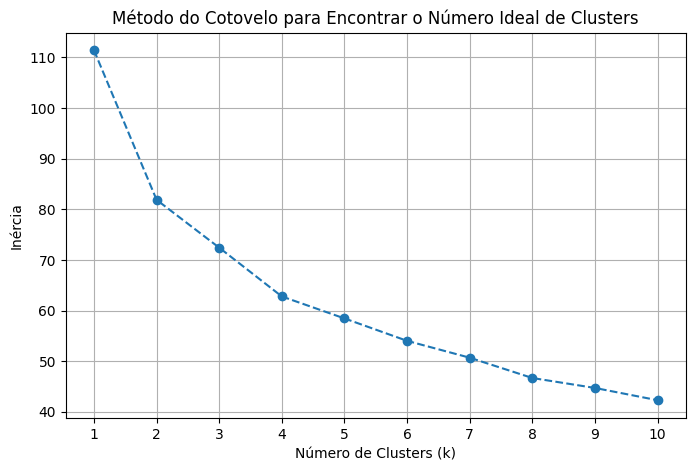

Cluster
0          40
1          36
2          24
Name: count, dtype: int64
Centroides dos clusters:
         Água    Celular         Luz    Internet  Aluguel      Cartão  Lazer  \
0  109.750000  55.000000  150.000000  104.000000    950.0  512.500000  195.0   
1  109.166667  73.888889  146.666667  102.222222   1500.0  633.333333  360.0   
2  110.416667  47.500000  155.000000  109.166667   1375.0  456.250000  322.5   

      Apostas  Emprego Fixo       Bicos  
0  150.000000        2750.0  450.000000  
1  338.888889        5500.0  433.333333  
2   75.000000        4875.0  475.000000  
Interpretação dos Clusters:
Cluster 0:
Água             109.75
Celular           55.00
Luz              150.00
Internet         104.00
Aluguel          950.00
Cartão           512.50
Lazer            195.00
Apostas          150.00
Emprego Fixo    2750.00
Bicos            450.00
Name: 0, dtype: float64
---
Cluster 1:
Água             109.166667
Celular           73.888889
Luz              146.666667
Internet

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


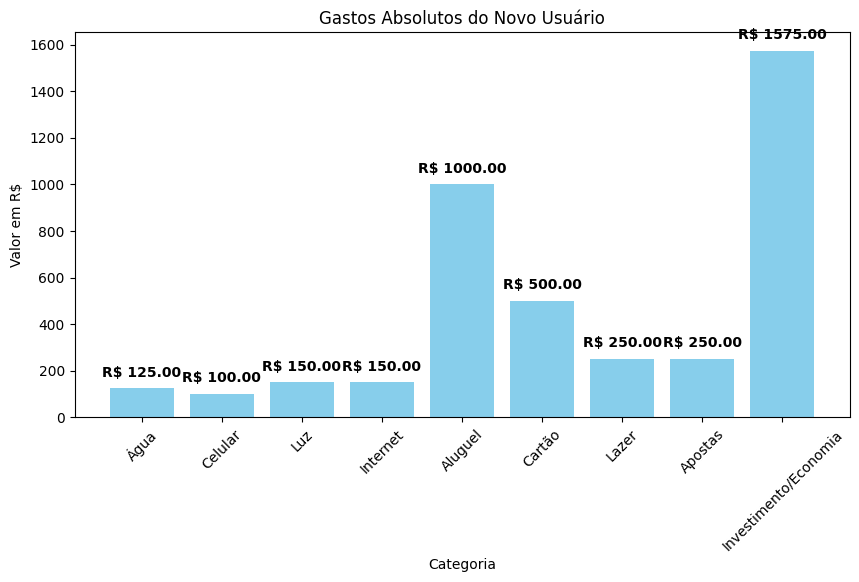

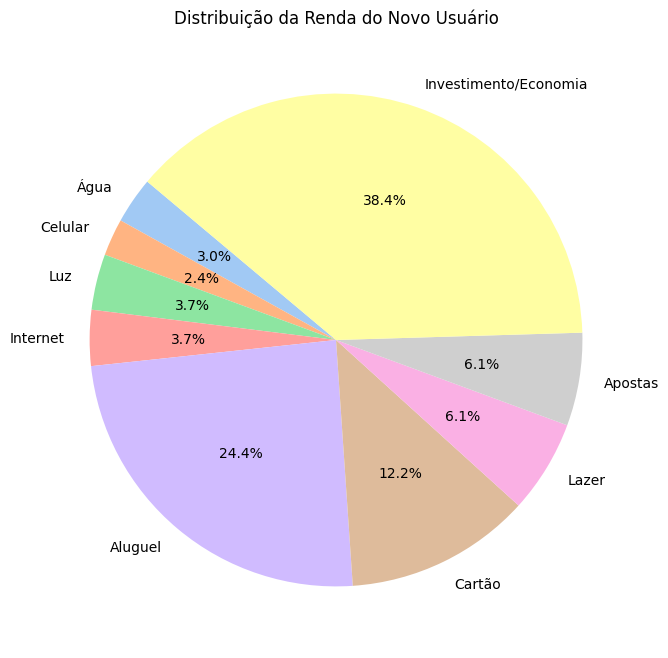

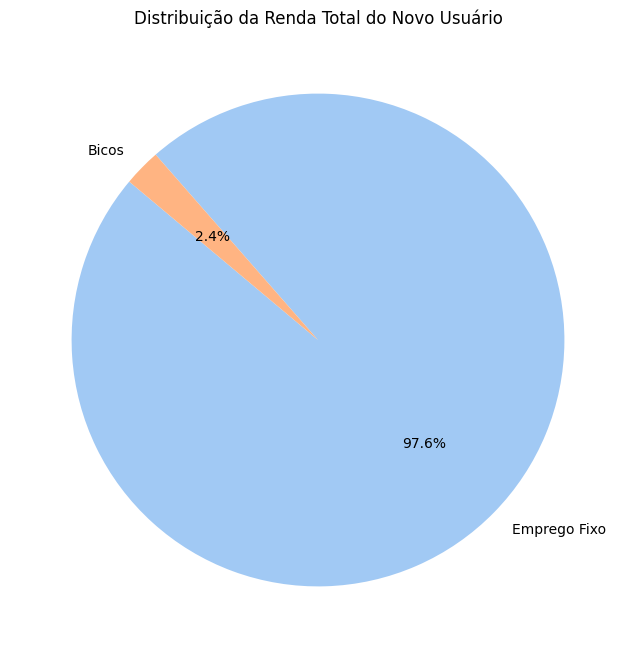

Maiores gastos em relação ao orçamento: [('Investimento/Economia', 38.41463414634146), ('Aluguel', 24.390243902439025), ('Cartão', 12.195121951219512)]
O novo usuário pertence ao cluster 1: Equilibrado: Gasta de forma controlada e mantém uma boa organização financeira.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


dataframe = pd.read_excel('Analíse_relaçao_economiasEgastos.xlsx')


features = ['Água', 'Celular', 'Luz', 'Internet', 'Aluguel', 'Cartão', 'Lazer', 'Apostas', 'Emprego Fixo', 'Bicos']
dataframe = dataframe[features]


scaler = MinMaxScaler()
dataframe_normalizadoGeral = pd.DataFrame(scaler.fit_transform(dataframe), columns=features)

#  Número ideal de clusters usando o método do cotovelo
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dataframe_normalizadoGeral)
    inertias.append(kmeans.inertia_)

# Cotovelo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Encontrar o Número Ideal de Clusters')
plt.xticks(k_values)
plt.grid()
plt.show()


k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
dataframe_normalizadoGeral['Cluster'] = kmeans.fit_predict(dataframe_normalizadoGeral)
print(dataframe_normalizadoGeral[['Cluster']].value_counts())

# Os centróides
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Centroides dos clusters:")
print(centroids)


print("Interpretação dos Clusters:")
for i, row in centroids.iterrows():
    print(f"Cluster {i}:")
    print(row)
    print("---")


dataframe_normalizadoGeral.to_excel('dataframe_segmentado.xlsx')

# KNN para classificação de novos usuários
knn = KNeighborsClassifier(n_neighbors=3)
X_train = dataframe_normalizadoGeral[features]
y_train = dataframe_normalizadoGeral['Cluster']
knn.fit(X_train, y_train)

# Modelo supervisionado para prever padrões de desperdício
X_train, X_test, y_train, y_test = train_test_split(dataframe_normalizadoGeral[features], dataframe_normalizadoGeral['Cluster'], test_size=0.2, random_state=42)
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)
print("Acurácia do modelo de regressão logística:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))


def classificar_novo_usuario(novo_usuario):
    novo_usuario_df = pd.DataFrame([novo_usuario], columns=features)
    novo_usuario_normalizado = scaler.transform(novo_usuario_df)
    cluster_predito = knn.predict(novo_usuario_normalizado)[0]

    descricao_clusters = {
        0: "Econômico: Gasta pouco e economiza bem, mas falta investir.",
        1: "Equilibrado: Gasta de forma controlada e mantém uma boa organização financeira.",
        2: "Gastador: Gasta muito e pode ter desperdícios, precisa de mais controle financeiro.",

    }


    orcamento_total = novo_usuario['Emprego Fixo'] + novo_usuario['Bicos']
    despesas = {k: v for k, v in novo_usuario.items() if k not in ['Emprego Fixo', 'Bicos']}
    despesas_percentuais = {k: (v / orcamento_total) * 100 for k, v in despesas.items()}


    soma_gastos = sum(despesas.values())
    economia = orcamento_total - soma_gastos if soma_gastos < orcamento_total else 0
    despesas["Investimento/Economia"] = economia
    despesas_percentuais["Investimento/Economia"] = (economia / orcamento_total) * 100 if economia > 0 else 0


    maiores_gastos = sorted(despesas_percentuais.items(), key=lambda x: x[1], reverse=True)[:3]
    alerta = f"Maiores gastos em relação ao orçamento: {maiores_gastos}"


    plt.figure(figsize=(10, 5))
    plt.bar(despesas.keys(), despesas.values(), color='skyblue')
    plt.xlabel('Categoria')
    plt.ylabel('Valor em R$')
    plt.title('Gastos Absolutos do Novo Usuário')
    plt.xticks(rotation=45)


    for i, (categoria, valor) in enumerate(despesas.items()):
        plt.text(i, valor + 50, f'R$ {valor:.2f}', ha='center', fontsize=10, fontweight='bold')

    plt.show()


    plt.figure(figsize=(8, 8))
    plt.pie(despesas_percentuais.values(), labels=despesas_percentuais.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Distribuição da Renda do Novo Usuário')
    plt.show()


    renda = {'Emprego Fixo': novo_usuario['Emprego Fixo'], 'Bicos': novo_usuario['Bicos']}
    plt.figure(figsize=(8, 8))
    plt.pie(renda.values(), labels=renda.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Distribuição da Renda Total do Novo Usuário')
    plt.show()

    print(alerta)
    print(f"O novo usuário pertence ao cluster {cluster_predito}: {descricao_clusters[cluster_predito]}")

    return cluster_predito, descricao_clusters[cluster_predito]


novo_usuario = {
    'Água': 125, 'Celular': 100, 'Luz': 150, 'Internet': 150, 'Aluguel': 1000,
    'Cartão': 500, 'Lazer': 250, 'Apostas': 250, 'Emprego Fixo': 4000, 'Bicos': 100
}

cluster_resultado, descricao = classificar_novo_usuario(novo_usuario)
